In [1]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import sys
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, ConcatDataset, Subset
# from torch.utils.data import sampler


import torchvision.datasets as dset
import torchvision.transforms as T

from PIL import Image

# disable warnings
Image.MAX_IMAGE_PIXELS = None # image processing
# auto-reload functions before each instance running them
%load_ext autoreload
%autoreload 2

In [2]:
# Remote instance set-up cell
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cpu


In [3]:
# directory setup cell
repo = 'tree-finder/'
location = 'google'

# Local paths
local_root = '/Users/etriesch/dev/'
colab_root = '/content/drive/My Drive/git/'
aws_root = '/home/ec2-user/'

# define root
if location == 'local':
  root = local_root
elif location == 'google':
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  root = colab_root
elif location == 'aws':
  root = aws_root

repo_path = root + repo
model_path = repo_path + 'models/'
data_path = repo_path + 'data/'
sys.path.append(repo_path)

Mounted at /content/drive


In [13]:
# setup cell
from notebooks.plot_fns import show_image_batch, set_plt_settings
from notebooks.data_processing import define_transforms, make_dataloaders, get_tree_class_likelihood, IMAGE_DIM, MEAN, STD
from notebooks.models import ResnetTransferClassifier
from notebooks.scrape_fns import get_filelist

set_plt_settings()

# Make dataset and loaders
This includes augmenting my dataset

In [6]:
# define transformations
transforms = define_transforms(scale_up=1024, crop=1024, scale_out=IMAGE_DIM, mean=MEAN, std=STD, mirror=True, randomcrop=[10,25,50])
# create dataset by concatenating all transformations
treeds = []
for t in transforms:
    df = dset.ImageFolder(root=data_path + 'images_spec', transform=transforms[t])
    treeds.append(df)

treeds = ConcatDataset(treeds)
class_names = treeds.datasets[0].classes

In [7]:
# make whole-dataset loader and sample loader
loader_all = DataLoader(dataset=treeds, batch_size=200, shuffle=False)

random_idxs = np.random.choice(range(len(treeds)), 200).tolist()
loader_samp = DataLoader(dataset=Subset(treeds, random_idxs), batch_size=6, shuffle=True)

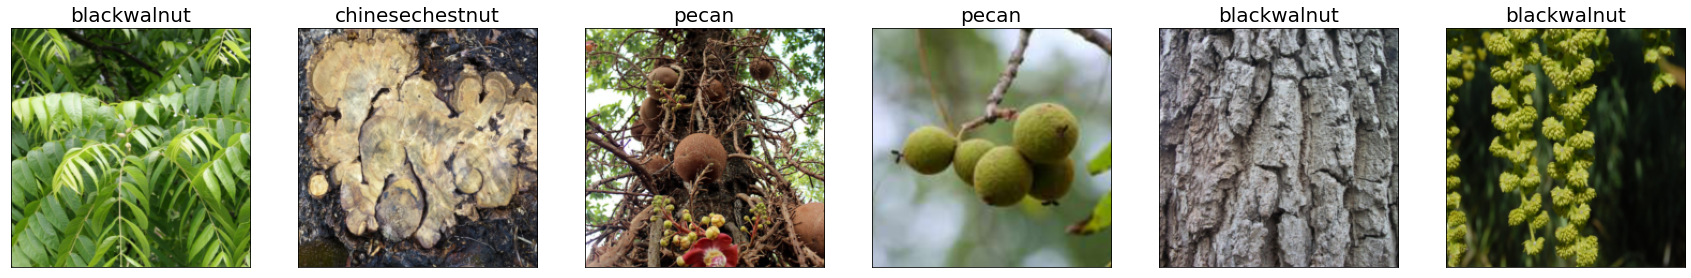

In [8]:
# visualize images
samp_imgs, samp_classes = next(iter(loader_samp))
samp_imgs.to(device), samp_classes.to(device)

# print(type(imgs), type(labels))
show_image_batch(samp_imgs, MEAN, STD, title=[class_names[x] for x in samp_classes])

# Generate indices to subset dataset, based on binary tree classifier

In [10]:
# load binary classifier
model = ResnetTransferClassifier(num_classes=2, retrain_last_cnblock=False)
model.load_state_dict(torch.load(model_path + 'ResnetBinClassifier.pt', map_location=torch.device('cpu')))
model.to(device)
model.eval()
print('success!')

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

success!


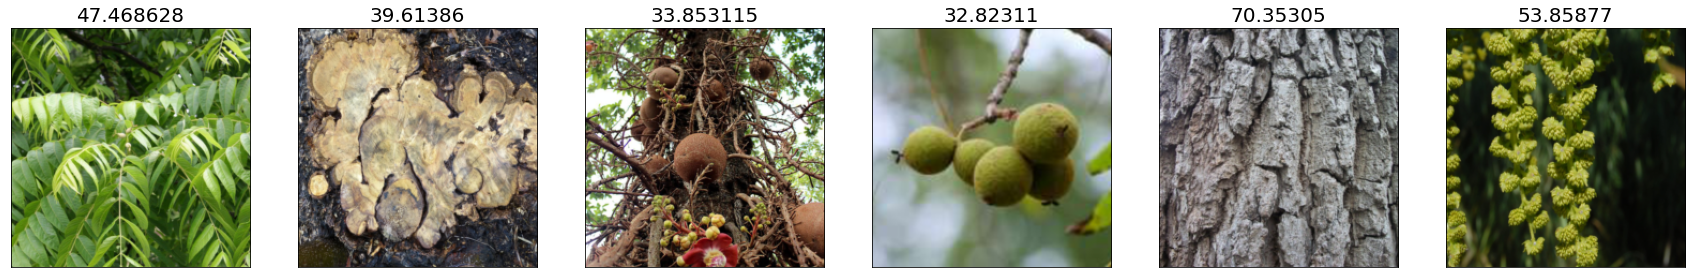

In [11]:
# print scores for sample of images
scores = model(samp_imgs)
percentage = F.softmax(scores, dim=1) * 100
# print trees and score for detecting tree for a random sample of images
tree_likelihood = percentage[:,1].detach().numpy()
show_image_batch(samp_imgs.cpu(), MEAN, STD, title=tree_likelihood)

In [15]:
# get indices for subsetting based on model classification
realtree_likelihood = get_tree_class_likelihood(classifier=model, loader=loader_samp, device=device)

 18%|█▊        | 6/34 [00:43<03:19,  7.12s/it]/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
100%|██████████| 34/34 [03:45<00:00,  6.62s/it]


In [32]:
# save to file
filename = 'images_spec_realtree_pcts.csv'
np.savetxt(data_path + filename, np.array(realtree_likelihood), delimiter=",", fmt='%1.4f')

In [30]:
threshold=0.55
flag = np.array(realtree_likelihood) > threshold
realtree_idxs = (np.arange(0, len(flag))[flag]).tolist()
print(f'\nimages meeting threshold ({threshold}): {sum(flag)} ({sum(flag)/len(flag):0.2%})')


images meeting threshold (0.55): 68 (34.00%)


# Summarize original, augmented, and subset datasets

In [24]:
tree_filelist, image_filelist = get_filelist(data_path + 'images_spec')

In [25]:
# original dataset
tree_summary = dict.fromkeys(tree_filelist.keys(), [0,0,0,0])
for k, i in tree_filelist.items():
  a = np.array(i)
  count_all = len(a)
  count_bing = len(a[np.char.startswith(a, 'bing-')])
  count_arbor = len(a[np.char.startswith(a, 'arborday-')])
  count_harvard = len(a[np.char.startswith(a, 'harvard-')])
  tree_summary[k] = [count_all, count_bing, count_arbor, count_harvard]

In [26]:
# augmented dataset
tree_summary_aug = tree_summary
for k in tree_summary.keys():
  tree_summary_aug[k] = [d*8 for d in tree_summary[k]]

In [27]:
# subset dataset
image_filelist_sub = np.array(image_filelist)[realtree_idxs]
tree_summary_sub = dict.fromkeys(tree_filelist.keys(), [0,0,0,0])
for k in tree_summary_sub.keys():
  a = image_filelist_sub[np.char.startswith(image_filelist_sub, k)]
  count_all = len(a)
  count_bing = len(a[np.char.startswith(a, 'bing-')])
  count_arbor = len(a[np.char.startswith(a, 'arborday-')])
  count_harvard = len(a[np.char.startswith(a, 'harvard-')])
  tree_summary_sub[k] = [count_all, count_bing, count_arbor, count_harvard]

In [28]:
# summary
print('original dataset (all, bing, arborday, harvard):')
print(tree_summary)
print('augmented dataset:')
print(tree_summary_aug)
print('filtered dataset:')
print(tree_summary_sub)

original dataset (all, bing, arborday, harvard):
{'blacklocust': [4840, 4496, 0, 344], 'blackwalnut': [5208, 4504, 32, 672], 'northernredoak': [4632, 4248, 56, 328], 'loblollypine': [3960, 3904, 56, 0], 'chinesechestnut': [5296, 3736, 24, 1536], 'honeylocust': [4008, 4008, 0, 0], 'pecan': [4888, 4728, 48, 112]}
augmented dataset:
{'blacklocust': [4840, 4496, 0, 344], 'blackwalnut': [5208, 4504, 32, 672], 'northernredoak': [4632, 4248, 56, 328], 'loblollypine': [3960, 3904, 56, 0], 'chinesechestnut': [5296, 3736, 24, 1536], 'honeylocust': [4008, 4008, 0, 0], 'pecan': [4888, 4728, 48, 112]}
filtered dataset:
{'blacklocust': [68, 0, 0, 0], 'blackwalnut': [0, 0, 0, 0], 'northernredoak': [0, 0, 0, 0], 'loblollypine': [0, 0, 0, 0], 'chinesechestnut': [0, 0, 0, 0], 'honeylocust': [0, 0, 0, 0], 'pecan': [0, 0, 0, 0]}


In [ ]:
# git saving cell
%cd '/content/drive/My Drive /git/tree-finder'
!git config --global user.email "erich.j.trieschman@gmail.com"
!git config --global user.name "Erich Trieschman"

!git add .
!git commit -m 'transfer learning models'
!git push

/content/drive/My Drive /git/tree-finder
[main ea85ecb] transfer learning models
 16 files changed, 1662 insertions(+), 542 deletions(-)
 create mode 100644 latex/PaperForReview.out
 create mode 100644 latex/PaperForReview.pdf
 create mode 100644 latex/README.md
 delete mode 100644 latex/README.txt
 create mode 100644 latex/RebuttalTemplate.pdf
 delete mode 100644 latex/egpaper_final.pdf
 delete mode 100644 latex/egpaper_final.synctex.gz
 delete mode 100644 latex/egpaper_final.tex
 delete mode 100644 latex/egpaper_for_review.pdf
 create mode 100644 latex/ieee_fullname.bst
 rewrite notebooks/preprocess_images.ipynb (75%)
 rewrite notebooks/train_binary_tree_classifier.ipynb (89%)
Counting objects: 16, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (16/16), done.
Writing objects: 100% (16/16), 2.40 MiB | 5.75 MiB/s, done.
Total 16 (delta 5), reused 0 (delta 0)
remote: Resolving deltas: 100% (5/5), completed with 5 local objects.
To https://github.com/etrieschman